# 농산물 품목 선별 기준을 위한 데이터 분석

## 데이터 분석 목표
- 농작물 수확 이득 예측을 위한 **품목 선별 기준을 수립**한다.
- **연간 도매 시세 변동 추이**를 분석하여, 안정적인 수익을 기대할 수 있는 품목을 선정한다.
- 분석 결과를 활용하여 **"농작물 수확 이득 예측 계산기"** 웹서비스의 기초 데이터를 구축한다.

## 데이터 개요  
- **분석 기간:** 최신 1년간 (총 12개월)  
- **데이터량:** 매월 **16,000개 이상**의 도매 시세 정보  
- **출처:** 농산물 유통 도매 시장 가격 데이터 


## 접근 방법 
1. 계산기에 사용될 품목을 10가지를 추린다.

    - 1차 선별: 거래량 및 지점 커버리지

        - 각 품목별 12개월 총 거래량 합산
        - 거래량 기준 상위 20-30개 품목 식별
        - 각 품목이 거래되는 지점 수 계산
        - 최소 20개 이상 지점에서 거래되는 품목만 유지

    - 2차 선별: 거래 금액 및 데이터 품질

        - 1차 선별된 품목들의 총 거래 금액 계산
        - 각 품목별 결측치 비율 확인
        - 각 품목들이 한 품목에 대해서 같은 달 동안 전국 모든 농협에서 변동성이 비교적 균일한 가격으로 품목들이 도매 거래되고 있는지 파악하기 위해서 변동 계수를 계산해본다.

    - 최종 선별: 카테고리 균형 및 다양성
        - 주요 카테고리별(채소, 과일, 곡물 등) 대표 품목 선정
        - 계절성을 고려한 품목 구성 (연중 품목과 계절 품목 균형)
        - 최종 10개 품목 확정

In [5]:

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 1. 데이터 통합

- 2024년 04월, 05월에 총변경물량 컬럼명이 다르므로 처리해주어야함 (하지 않으면 nan값으로 추가됨)

In [65]:

folder_path = './2023-24-도매시세' 

# 폴더 내 csv 파일 경로 리스트 생성
csv_file_list = glob.glob(os.path.join(folder_path, '*.csv'))

all_data = []

for file_path in csv_file_list:

    # 파일 읽어오기 
    df = pd.read_csv(file_path, encoding='euc-kr')
    
    # 'CHG_TOT_VOLM' 컬럼이 있는지 확인하고 이름 변경
    if 'CHG_TOT_VOLM' in df.columns:
        df.rename(columns={'CHG_TOT_VOLM': 'KG_CHG_TOT_VOLM'}, inplace=True)

    # 인덱스를 리셋하여 중복된 인덱스를 피함
    df.reset_index(drop=True, inplace=True)

    all_data.append(df)

print(all_data)


C:\Users\SUNA\AppData\Local\Temp\ipykernel_21632\1334300492.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
C:\Users\SUNA\AppData\Local\Temp\ipykernel_21632\1334300492.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
C:\Users\SUNA\AppData\Local\Temp\ipykernel_21632\1334300492.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')


[         AUC_YMD  NH_MTC_JTMK_CODE NH_MTC_JTMK_NM PDLT_CODE PDLT_NM  \
0       20230601          23000303        삼산원협(공)       902      호박   
1       20230601          31120101        농협구리(공)       806   방울토마토   
2       20230601          31040101        안양원협(공)       902      호박   
3       20230601          31010103        수원원협(공)       902      호박   
4       20230601          31040101        안양원협(공)       902      호박   
...          ...               ...            ...       ...     ...   
105074  20230619          22000105       농협북대구(공)      0614      감귤   
105075  20230619          38040101        진주원협(공)      0614      감귤   
105076  20230619          21000101        농협부산(공)      0659    블루베리   
105077  20230619          23000103        구월원협(공)      7609   우뭇가사리   
105078  20230619          21000903        농협반여(공)      0401     옥수수   

            MTC_NM  KG_CHG_TOT_VOLM  AUC_SFBD_TOT_AMNT      ETL_LDG_DT  
0           경기 화성시            640.0           814500.0  20230608064055  


In [66]:
# 모든 데이터프레임을 하나로 통합
combined_df = pd.concat(all_data, ignore_index=True)

# 통합 데이터프레임 기본 정보 확인
print(f"통합 데이터 크기: {combined_df.shape}")
print(f"총 품목 수: {combined_df['PDLT_NM'].nunique()}")

통합 데이터 크기: (1768391, 9)
총 품목 수: 286


In [8]:
# 통합 데이터 저장 (선택 사항)
combined_df.to_csv(os.path.join(folder_path, '통합_도매시세.csv'), index=False, encoding='euc-kr')

## 2. 1차 선별: 거래량 기준 상위 30개 품목 식별
- 각 품목별 12개월 총 거래량 합산
- 거래량 기준 상위 20-30개 품목 식별
- 각 품목이 거래되는 지점 수 계산
- 최소 20개 이상 지점에서 거래되는 품목만 유지

***

- 거래량 기준 상위 30개에 쌀이 없다?
    - 유통 구조의 차이: 쌀은 주로 정부나 대형 유통업체를 통해 유통되며, 농협 공판장과 같은 도매시장을 통한 거래는 비교적 적습니다. 이는 쌀의 유통 구조가 다른 농산물과 다르기 때문입니다.

    - 도매시장 품목 제한: 일부 농산물 도매시장은 특정 품목에 집중하며, 쌀은 그 대상에서 제외될 수 있습니다. 이는 각 도매시장의 운영 방침과 지역별 수요에 따라 다를 수 있습니다.

    - 지역별 유통 관행: 지역에 따라 쌀의 유통 경로가 다를 수 있습니다. 일부 지역에서는 쌀이 도매시장을 거치지 않고 직접 소비자나 소매점으로 유통되는 경우가 많습니다.

In [68]:
# 품목별 거래량 합계 계산
volume_by_products = combined_df.groupby('PDLT_NM')['KG_CHG_TOT_VOLM'].sum().sort_values(ascending=False)

# 상위 30개 품목 선택
top_volume_products = volume_by_products.head(30).index.tolist()

In [69]:
# 품목별 지점 커버리지 계산
coverage_by_item = combined_df.groupby('PDLT_NM')['NH_MTC_JTMK_CODE'].nunique()

# 20개 이상 지점에서 거래되는 품목 선택
well_covered_items = coverage_by_item[coverage_by_item >= 20].index.tolist()

In [70]:
# 1차 선별: 거래량 상위 & 충분한 지점 커버리지
first_filter_items = [item for item in top_volume_products if item in well_covered_items]
print(f"1차 선별 후 품목 수: {len(first_filter_items)}")
print("1차 선별 품목 목록:")
print(first_filter_items)

1차 선별 후 품목 수: 30
1차 선별 품목 목록:
['양파', '사과', '무', '배추', '수박', '오이', '감귤', '호박', '양배추', '감자', '대파', '바나나', '포도', '마늘', '배', '풋고추', '고구마', '토마토', '당근', '참외', '브로코리(녹색꽃양배추)', '복숭아', '딸기', '방울토마토', '상추', '단감', '새송이', '얼갈이배추', '팽이버섯', '열무']


- 특이 사항: 30개의 모든 품목이 20지점 이상에서 거래 되고 있음

## 3. 2차 선별: 거래 금액 및 데이터 품질

- 1KG당 거래 금액 column 생성 
    - AUC_SFBD_TOT_AMNT_PER_KG (1KG 당 가격) = AUC_SFBD_TOT_AMNT / KG_CHG_TOT_VOLM
- 1차 선별된 품목들의 1KG 당 거래 금액 계산
- 각 품목별 결측치 비율 확인
- 각 품목들이 한 품목에 대해서 같은 달 동안 전국 모든 농협에서 변동성이 비교적 균일한 가격으로 품목들이 도매 거래되고 있는지 파악하기 위해서 변동 계수를 계산해본다.

In [83]:
# 1KG 당 거래액 컬럼 추가
combined_df['AUC_SFBD_TOT_AMNT_PER_KG'] = combined_df['AUC_SFBD_TOT_AMNT'] / combined_df['KG_CHG_TOT_VOLM']

In [125]:
# 품목별 1KG당 거래 금액의 총 금액(1년 치) 계산
amount_by_item = combined_df.groupby('PDLT_NM')['AUC_SFBD_TOT_AMNT_PER_KG'].sum().sort_values(ascending=False)

# 결측치 비율 계산 함수
def calculate_missing_ratio(item_name):
    item_data = combined_df[combined_df['PDLT_NM'] == item_name]
    # 지점과 날짜의 모든 조합 수 계산
    total_possible = len(combined_df['NH_MTC_JTMK_CODE'].unique()) * len(combined_df['AUC_YMD'].unique())
    actual_records = len(item_data)
    return 1 - (actual_records / total_possible)

# 1차 선별된 품목들의 결측치 비율 계산
missing_ratio = {item: calculate_missing_ratio(item) for item in first_filter_items}

# 결측치가 1% 미만인 품목 선택
quality_items = [item for item in first_filter_items if missing_ratio[item] < 0.01]
print(f"결측치가 1% 미만인 품목 목록: {len(quality_items)}개")
print(quality_items)

결측치가 1% 미만인 품목 목록: 30개
['양파', '사과', '무', '배추', '수박', '오이', '감귤', '호박', '양배추', '감자', '대파', '바나나', '포도', '마늘', '배', '풋고추', '고구마', '토마토', '당근', '참외', '브로코리(녹색꽃양배추)', '복숭아', '딸기', '방울토마토', '상추', '단감', '새송이', '얼갈이배추', '팽이버섯', '열무']


In [85]:
# 1. 날짜, 품목별로 각 농협 간 가격 차이 분석
def analyze_price_differences(df, selected_items):
    # 선택된 품목만 필터링
    filtered_df = df[df['PDLT_NM'].isin(selected_items)]
    
    # 결과를 저장할 빈 데이터프레임 초기화
    results = []
    
    # 각 날짜와 품목별로 분석
    for (date, item), group in filtered_df.groupby(['AUC_YMD', 'PDLT_NM']):
        # 또는 문자열로 변환 후 추출

        # 해당 그룹 내 kg당 가격의 통계치 계산
        price_stats = {
            'date': str(date),
            'item': item,
            'mean_price': group['AUC_SFBD_TOT_AMNT_PER_KG'].mean(),
            'min_price': group['AUC_SFBD_TOT_AMNT_PER_KG'].min(),
            'max_price': group['AUC_SFBD_TOT_AMNT_PER_KG'].max(),
            'std_price': group['AUC_SFBD_TOT_AMNT_PER_KG'].std(),
            'price_range': group['AUC_SFBD_TOT_AMNT_PER_KG'].max() - group['AUC_SFBD_TOT_AMNT_PER_KG'].min(),
            'cv': group['AUC_SFBD_TOT_AMNT_PER_KG'].std() / group['AUC_SFBD_TOT_AMNT_PER_KG'].mean() if group['AUC_SFBD_TOT_AMNT_PER_KG'].mean() > 0 else 0,
            'num_coops': len(group) # 해당 날짜/품목에 대한 농협 수
        }
        results.append(price_stats)
    
    # 결과를 데이터프레임으로 변환
    result_df = pd.DataFrame(results)
    
    return result_df

In [86]:
# 2. 각 품목별 농협 간 가격 차이의 분포 시각화
def visualize_price_differences(result_df):
    # 품목별 변동 계수(CV) 평균 계산
    item_cv = result_df.groupby('item')['cv'].mean().sort_values(ascending=False)

    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'Malgun Gothic'
    
    # 1. 품목별 평균 변동 계수 시각화
    plt.figure(figsize=(12, 6))
    item_cv.plot(kind='bar', color='skyblue')
    plt.title('품목별 농협 간 가격 차이 (평균 변동 계수)')
    plt.ylabel('평균 변동 계수 (CV)')
    plt.xlabel('품목')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. 박스플롯으로 품목별 변동 계수 분포 비교
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='item', y='cv', data=result_df)
    plt.title('품목별 농협 간 가격 차이 분포')
    plt.ylabel('변동 계수 (CV)')
    plt.xlabel('품목')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. 히트맵으로 시간에 따른 품목별 변동 계수 시각화
    # 날짜를 datetime으로 변환
    result_df['date'] = pd.to_datetime(result_df['date'])
    result_df['month'] = result_df['date'].dt.month
    
    # 월별, 품목별로 평균 변동 계수 계산
    monthly_cv = result_df.groupby(['month', 'item'])['cv'].mean().unstack()
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(monthly_cv, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('월별 품목별 농협 간 가격 차이 (변동 계수)')
    plt.ylabel('월')
    plt.xlabel('품목')
    plt.tight_layout()
    plt.show()
    
    return item_cv

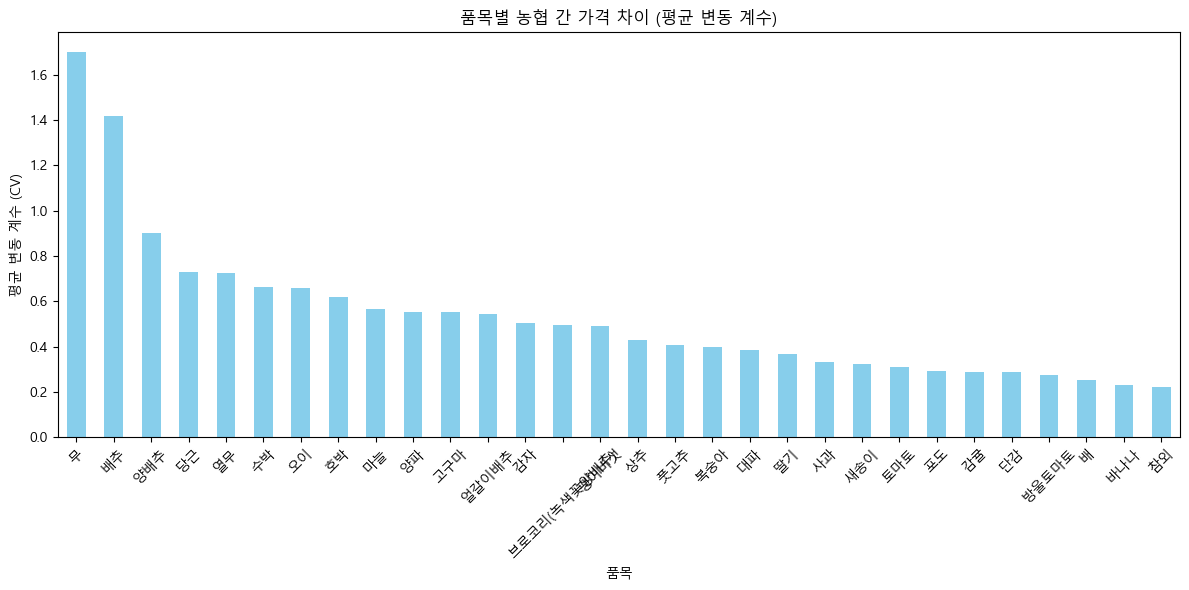

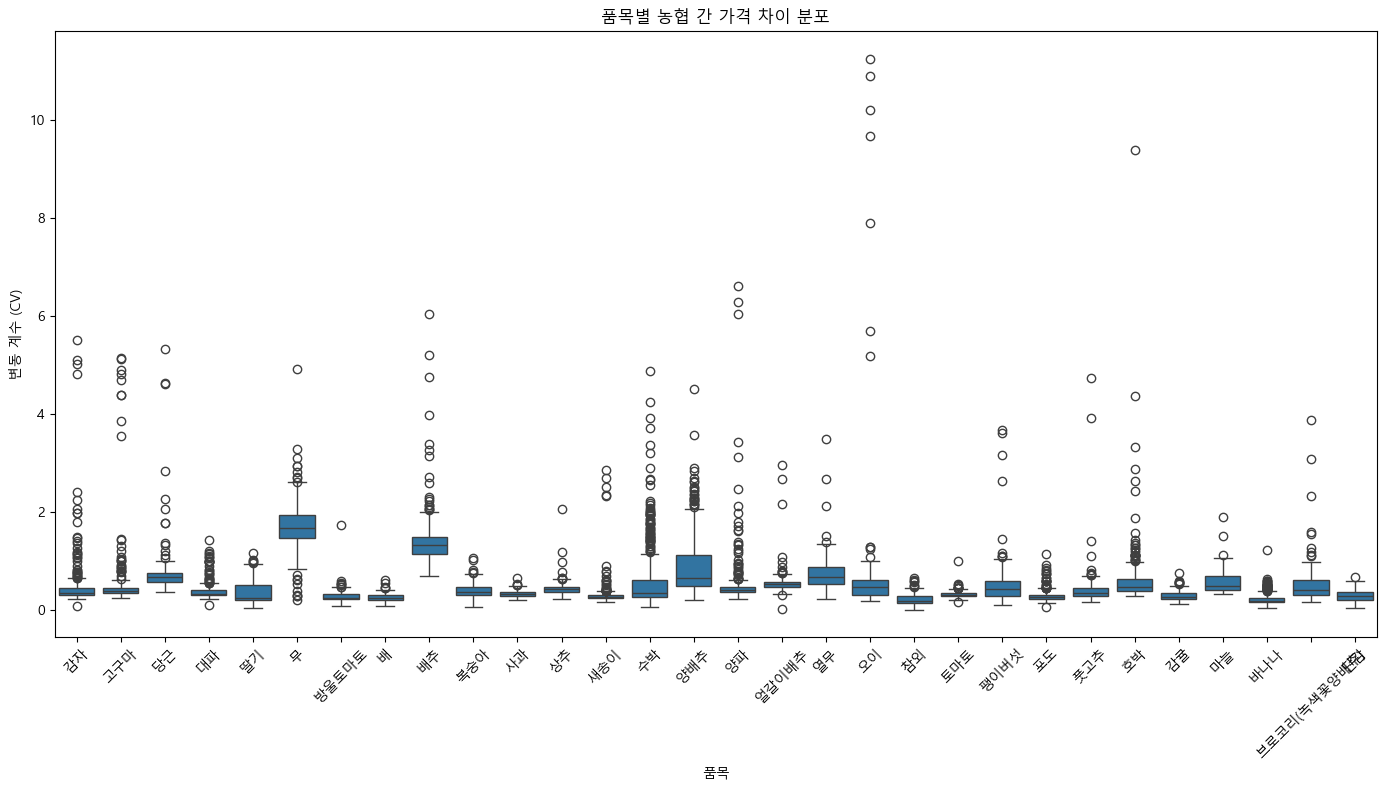

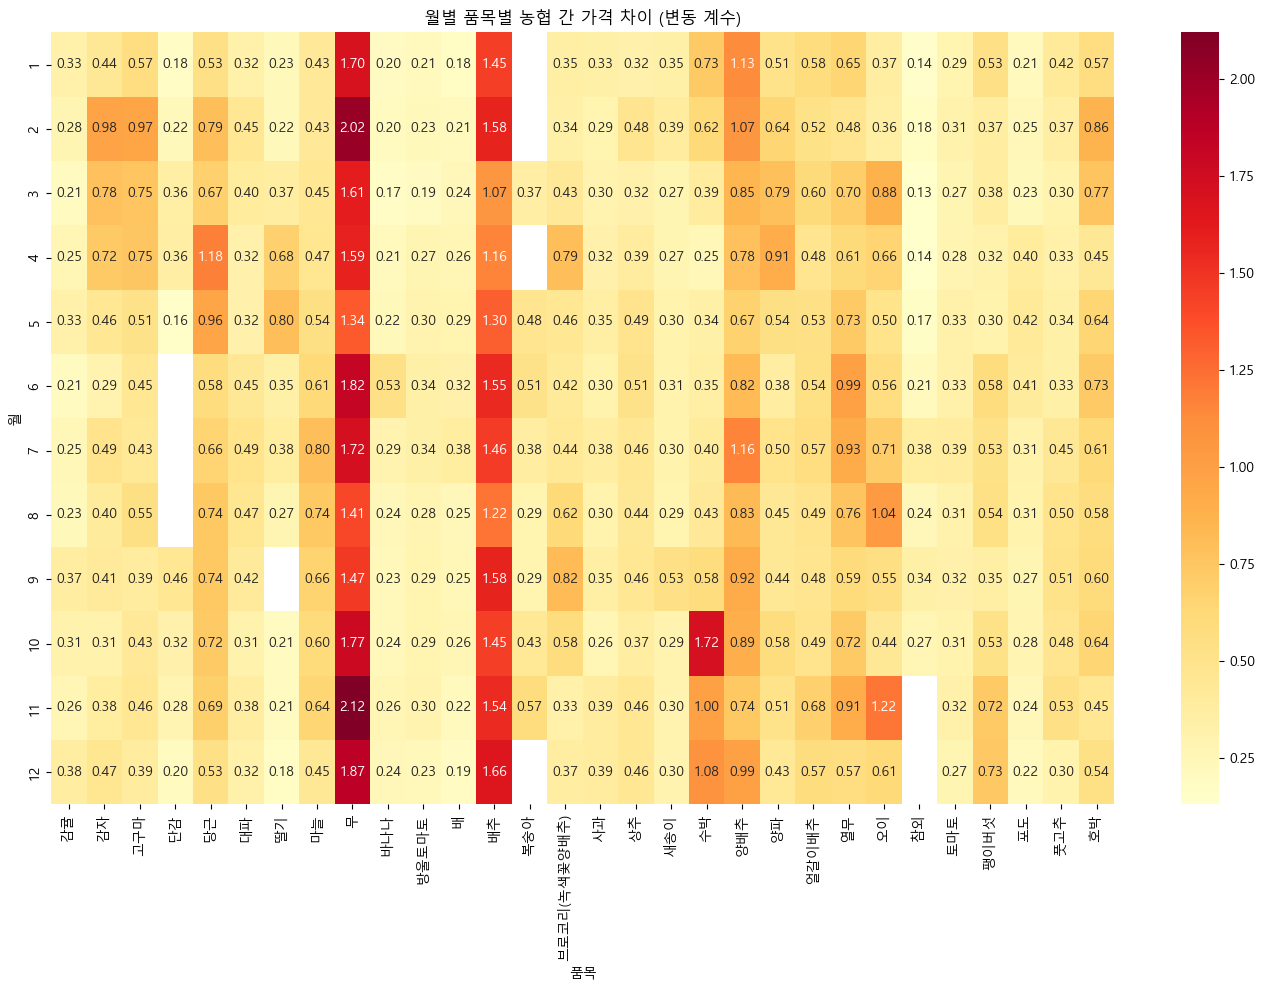

In [97]:
# 실행
selected_items = quality_items
result_df = analyze_price_differences(combined_df, selected_items)
item_cv = visualize_price_differences(result_df)

- 변동 계수는 데이터의 상대적인 변동성을 나타내는 지표 (표준편차/평균)
    - 변동 계수가 작을수록 상대적 변동성이 낮음
    - 일반적으로 변동 계수 < 10% 이면 상대적으로 변동성이 적고 신뢰할 수 있는 데이터로 간주

- 거래량이 높은 상위 30개 품목 모두 변동 계수가 5% 미만으로 **한 품목에 대해서 같은 달 동안 전국 모든 농협에서 변동성이 비교적 균일한 가격으로 품목들이 도매 거래** 되고 있다는 의미이다.

- 한 달간 거래된 한 품목에 대해서 모든 농협에서의 시세 평균을 내더라도 신뢰할만한 데이터라고 간주할 수 있다.

- 히트맵에서 빈칸은 한 달 내에 거래 데이터가 한 개 이하라 결과를 측정할 수 없었던 품목이다. 해당 품목은 품목 선별 대상에서 제외한다. (단감, 딸기, 복숭아, 참외)

In [127]:
second_filter_items = sorted(quality_items, key=lambda x: amount_by_item.get(x, 0), reverse=True)

# second_filter_items에서 단감, 딸기, 복숭아, 참외 제외
second_filter_items.remove('단감')
second_filter_items.remove('딸기')
second_filter_items.remove('복숭아')
second_filter_items.remove('참외')

## 4. 3단계: 계절성 분석을 통한 최종 품목 선정

- 주요 카테고리별(채소, 과일 등) 대표 품목 선정
- 계절성을 고려한 품목 구성 (연중 품목과 계절 품목 균형)
- 최종 10개 품목 확정

In [129]:
# 카테고리 수동 정의
category_dict = {
    '사과': '과일', '수박': '과일', '배': '과일', '바나나': '과일',
    '양파': '채소', '오이': '채소', '호박': '채소', '대파': '채소', '배추': '채소', '마늘': '채소', 
    '풋고추': '채소', '토마토': '채소', '방울토마토': '채소',
    '감귤': '과일', '감자': '채소', '고구마': '채소', '브로코리(녹색꽃양배추)': '채소', '포도': '과일', '새송이': '버섯', '얼갈이배추': '채소', 
    '팽이버섯': '버섯', '열무': '채소', '상추': '채소', '당근': '채소', '무': '채소', '양배추': '채소',
}

# 계절성 분석을 위한 월 정보 추출

# 데이터 타입 확인
# print(combined_df['AUC_YMD'].dtype) - int64

# 또는 문자열로 변환 후 추출
combined_df['AUC_MON'] = combined_df['AUC_YMD'].astype(str).str[4:6].astype(int)

In [130]:
# 계절성 분석을 위한 월별 거래량 계산
def analyze_seasonality(item_name):
    item_data = combined_df[combined_df['PDLT_NM'] == item_name]
    monthly_volume = item_data.groupby('AUC_MON')['KG_CHG_TOT_VOLM'].sum()
    return monthly_volume

# 각 품목의 계절성 분석
seasonality_data = {}
for item in second_filter_items:
    seasonality_data[item] = analyze_seasonality(item)


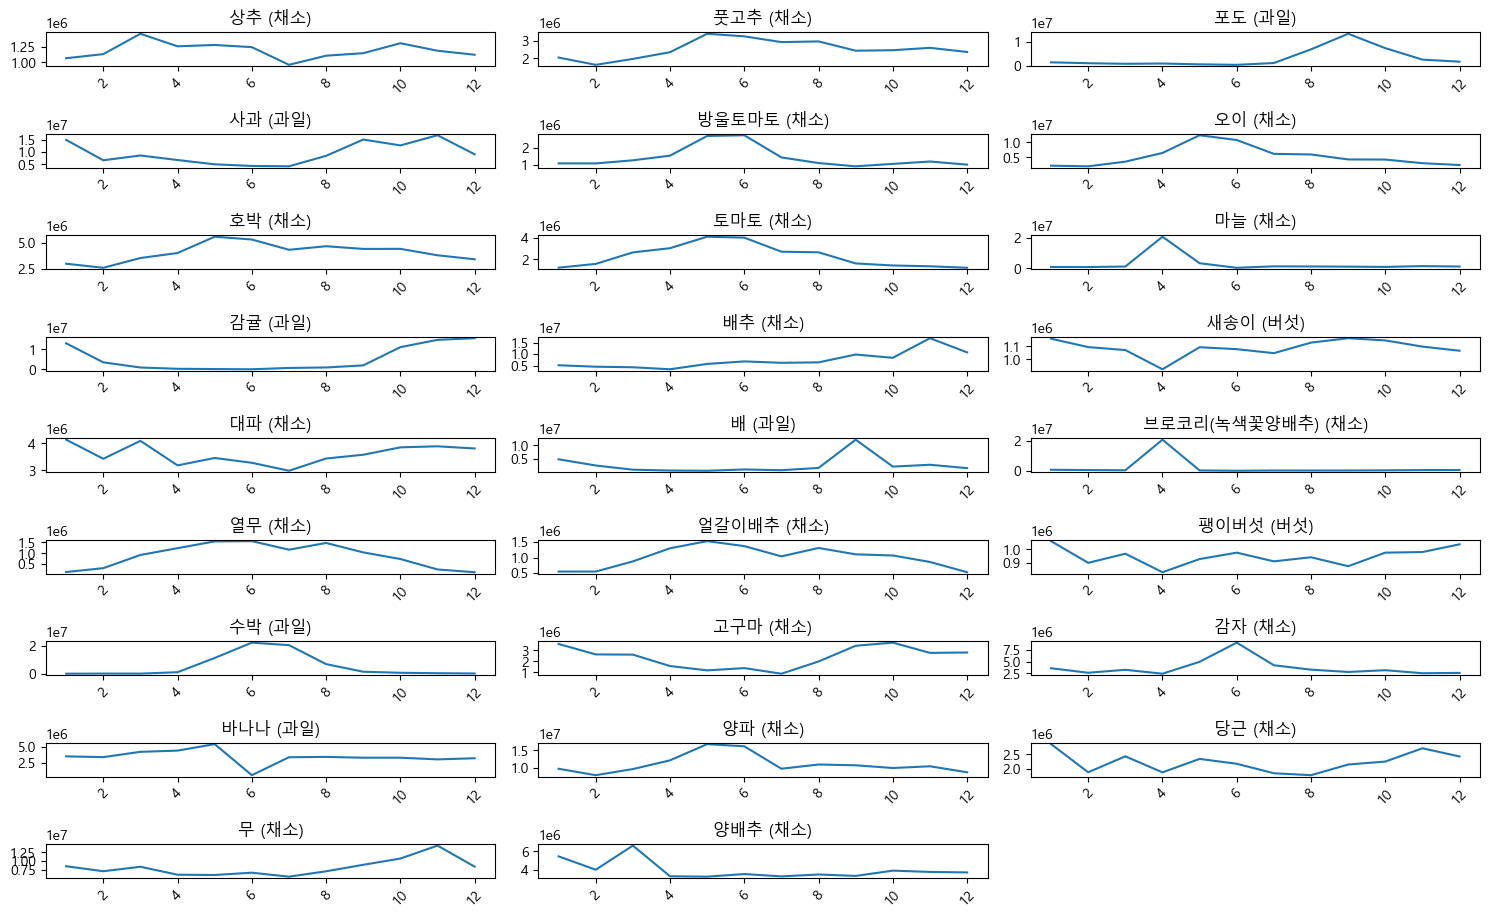

In [131]:

# 시각화: 월별 거래 패턴
plt.figure(figsize=(15, 10))
for i, item in enumerate(second_filter_items, 1):
    plt.subplot(10, 3, i)
    monthly_data = seasonality_data[item]
    plt.plot(monthly_data.index, monthly_data.values)
    plt.title(f"{item} ({category_dict[item]})")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [132]:
# 계절성 점수 계산 (변동계수 활용)
seasonality_score = {}
for item, monthly_data in seasonality_data.items():
    cv = monthly_data.std() / monthly_data.mean() if monthly_data.mean() > 0 else 0
    seasonality_score[item] = cv

# 계절성 점수에 따른 분류
year_round_items = [item for item, score in seasonality_score.items() if score < 0.3]
seasonal_items = [item for item, score in seasonality_score.items() if score >= 0.3]

print("연중 품목:", year_round_items)
print("계절 품목:", seasonal_items)

연중 품목: ['상추', '풋고추', '호박', '새송이', '대파', '팽이버섯', '양파', '당근', '양배추']
계절 품목: ['포도', '사과', '방울토마토', '오이', '토마토', '마늘', '감귤', '배추', '배', '브로코리(녹색꽃양배추)', '열무', '얼갈이배추', '수박', '고구마', '감자', '바나나', '무']


In [133]:
# 카테고리별 집계
category_counts = {}
for item in second_filter_items:
    category = category_dict[item]
    if category not in category_counts:
        category_counts[category] = []
    category_counts[category].append(item)

print("카테고리별 품목 수:")
for category, items in category_counts.items():
    print(f"{category}: {len(items)}개 - {', '.join(items)}")

카테고리별 품목 수:
채소: 18개 - 상추, 풋고추, 방울토마토, 오이, 호박, 토마토, 마늘, 배추, 대파, 브로코리(녹색꽃양배추), 열무, 얼갈이배추, 고구마, 감자, 양파, 당근, 무, 양배추
과일: 6개 - 포도, 사과, 감귤, 배, 수박, 바나나
버섯: 2개 - 새송이, 팽이버섯


## 5. 최종 선정

<최종선정 기준>
- 국내에서 대중적으로 재배되는 품목
- 수입 의존도가 낮은 품목
- 과일과 채소 카테고리의 균형 (5:5 비율)
- 다양한 재배 방식 포함 (노지, 시설 등)
- 연중 재배 작물과 계절 작물 카테고리 균형
- 계절성 특성 반영 (여름 작물, 겨울 작물 포함)

---

#### 과일 카테고리 (5개)

- **사과** -  가을철 대표 과일, 수입 의존도 낮음
- **감귤** -  겨울철 대표 과일, 수입 의존도 낮음, 시설, 노지 모두 재배 가능
- **수박** - 여름철 대표 과일, 수입 의존도 낮음
- **배** - 가을철 대표 과일, 수입 의존도 낮음
- **포도** - 여름철 대표 과일, 시설, 노지 모두 재배 가능

#### 채소 카테고리 (5개)

- **양파** - 연중 생산 가능, 수입 의존도 낮음, 다양한 재배 방식
- **대파** - 연중 재배, 수입 의존도 낮음, 다양한 재배 방식
- **오이** - 여름 작물, 수입 의존도 낮음, 시설 재배
- **상추** - 연중 재배, 수입 의존도 낮음, 여름 소비
- **고구마** -연중 재배, 수입 의존도 낮음 

#### 사과, 감귤, 수박, 배, 포도, 양파, 대파, 오이, 상추, 고구마